In [1]:
import os
import sys
from pathlib import Path

# FOR LOCAL USE THIS LINES
# current = Path.cwd()
# src_path = current / "src" if (current / "src").exists() else current.parent

# FOR COLAB USE THIS LINE INSTEAD
# After -b insert the branch name if needed
!git clone -b s2_refactoring https://github.com/MatteoCamillo-code/GeoLoc-CVCS.git
!cd /content/GeoLoc-CVCS && git pull origin s2_refactoring && cd ..
src_path = Path("/content/GeoLoc-CVCS/src").resolve()

sys.path.insert(0, str(src_path))

from utils.paths import find_project_root

# Set working directory and sys.path properly
project_root = find_project_root(src_path)
DATA_DIR = project_root / "data"
os.chdir(project_root)
sys.path.insert(0, str(project_root / "src"))
print("CWD:", Path.cwd())

fatal: destination path 'GeoLoc-CVCS' already exists and is not an empty directory.
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 3), reused 7 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 3.67 KiB | 1.22 MiB/s, done.
From https://github.com/MatteoCamillo-code/GeoLoc-CVCS
 * branch            s2_refactoring -> FETCH_HEAD
   2254e81..4d354ab  s2_refactoring -> origin/s2_refactoring
Updating 2254e81..4d354ab
Fast-forward
 src/map_partitioning/s2/plotting.py | 82 ++++++++++++++++++++++++++++++++++---
 src/map_partitioning/s2/utils.py    | 51 ++++++++++++++++++++++-
 2 files changed, 127 insertions(+), 6 deletions(-)
CWD: /content/GeoLoc-CVCS


In [2]:
!cd /content/GeoLoc-CVCS/ && git branch -r 

  origin/HEAD -> origin/main
  origin/architecture
  origin/main
  origin/refactoring
  origin/s2_refactoring
  origin/windows


In [3]:
!pip install s2sphere

In [4]:
import pandas as pd
import geopandas as gpd

import src.map_partitioning.s2.config as cfg
from src.map_partitioning.s2.plotting import plot_density_map, plot_s2_cell_maps_trio, plot_s2_cell_maps
from src.map_partitioning.s2.utils import get_s2_cell_id, perform_train_val_split, create_cell_center_dataset
from src.map_partitioning.s2.partition import s2_partitioning

In [5]:
# --- 1. DATA LOADING & INITIAL S2 PROCESSING ---
print("Loading data...")
df = pd.read_csv(cfg.INPUT_TRAIN)

# Generate S2 cells at the most granular level (Level 30)
print("Generating S2 Cell IDs for all points...")
df['s2_cell'] = [
    get_s2_cell_id(lat, lng) 
    for lat, lng in zip(df['latitude'], df['longitude'])
]

Loading data...
Generating S2 Cell IDs for all points...


In [6]:
# --- 2. TRAIN/VAL SPLIT ---
print("Performing Train/Validation split...")
df_train, df_val = perform_train_val_split(df)

Performing Train/Validation split...


Loading USA map for density plot...


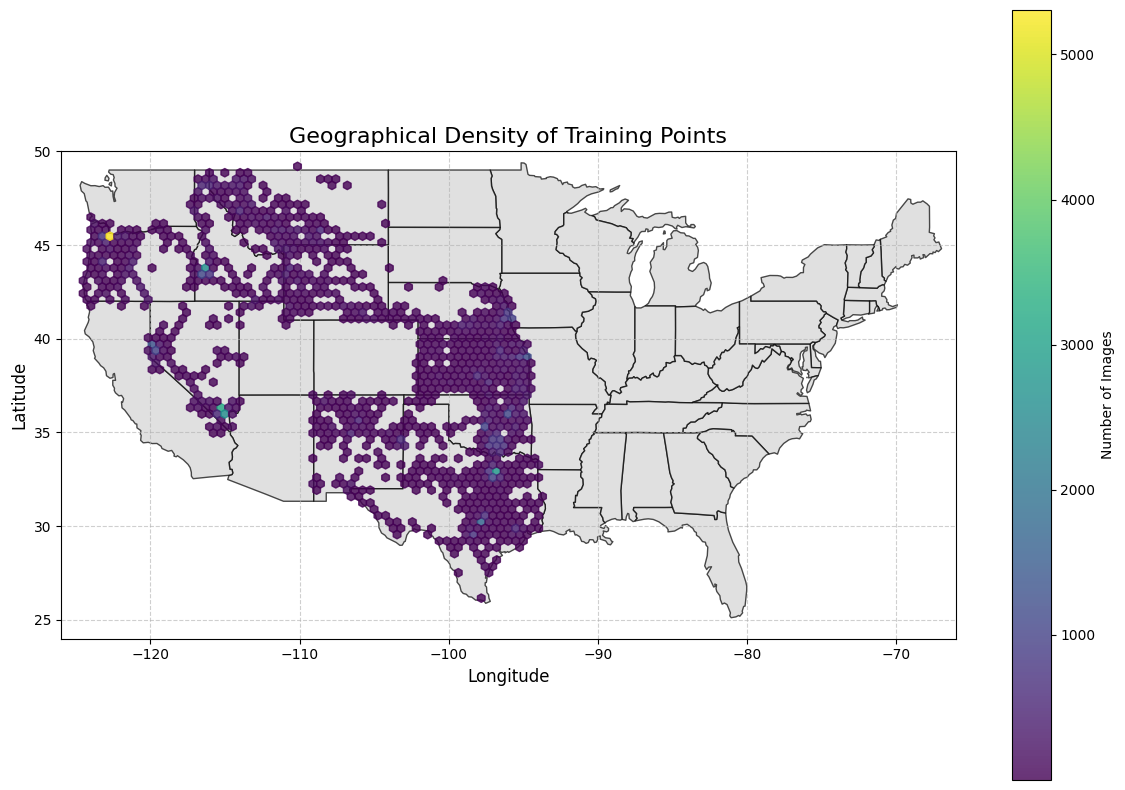


Density Map Completed


In [7]:
# --- 3. VISUALIZATION: DENSITY MAP ---
plot_density_map(
    df_train, 
    title="Geographical Density of Training Points", 
    x_label="Longitude", 
    y_label="Latitude"
)

In [8]:
# --- 4. RUN S2 PARTITIONING ---
trained_partitions, trained_lookups, df_train = s2_partitioning(
    df_train, 
    cfg.PARTITION_CONFIGS
)


Starting S2 Cell Partitioning and Labeling

Partitioning config_1 (tau_max=50)...
Number of cells (classes) created: 4742


 Mapping config_1: 100%|██████████| 101156/101156 [00:04<00:00, 20649.50it/s]



Partitioning config_2 (tau_max=100)...
Number of cells (classes) created: 2509


 Mapping config_2: 100%|██████████| 101156/101156 [00:04<00:00, 22184.02it/s]



Partitioning config_3 (tau_max=200)...
Number of cells (classes) created: 1337


 Mapping config_3: 100%|██████████| 101156/101156 [00:05<00:00, 17593.65it/s]


 
S2 Cell Partitioning and Labeling completed.


Loading USA map for visualization...


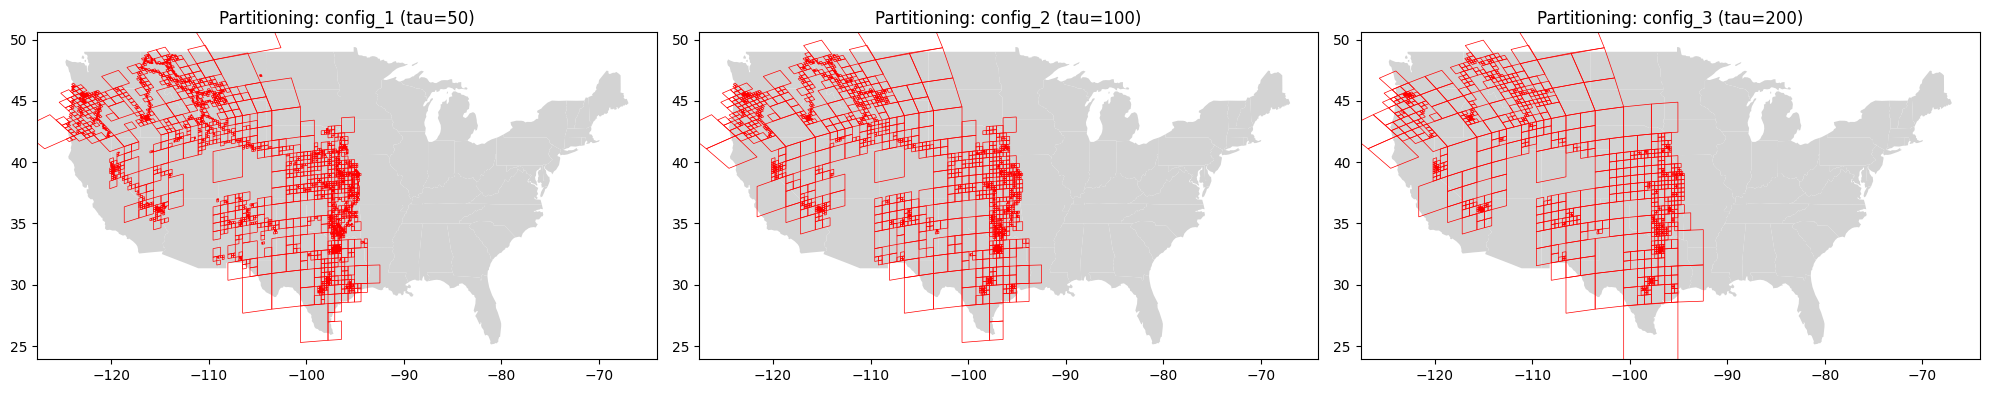

In [9]:
# --- 5. VISUALIZATION: S2 CELL GRID ---
print("Loading USA map for visualization...")
usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(usa_url)
usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Plot the resulting grids for each config side-by-side
plot_s2_cell_maps_trio(
    cfg.PARTITION_CONFIGS, 
    trained_partitions, 
    df_train, 
    usa, 
    #save_images=True, 
    #output_dir=tbd
)

Generating S2 cell maps...


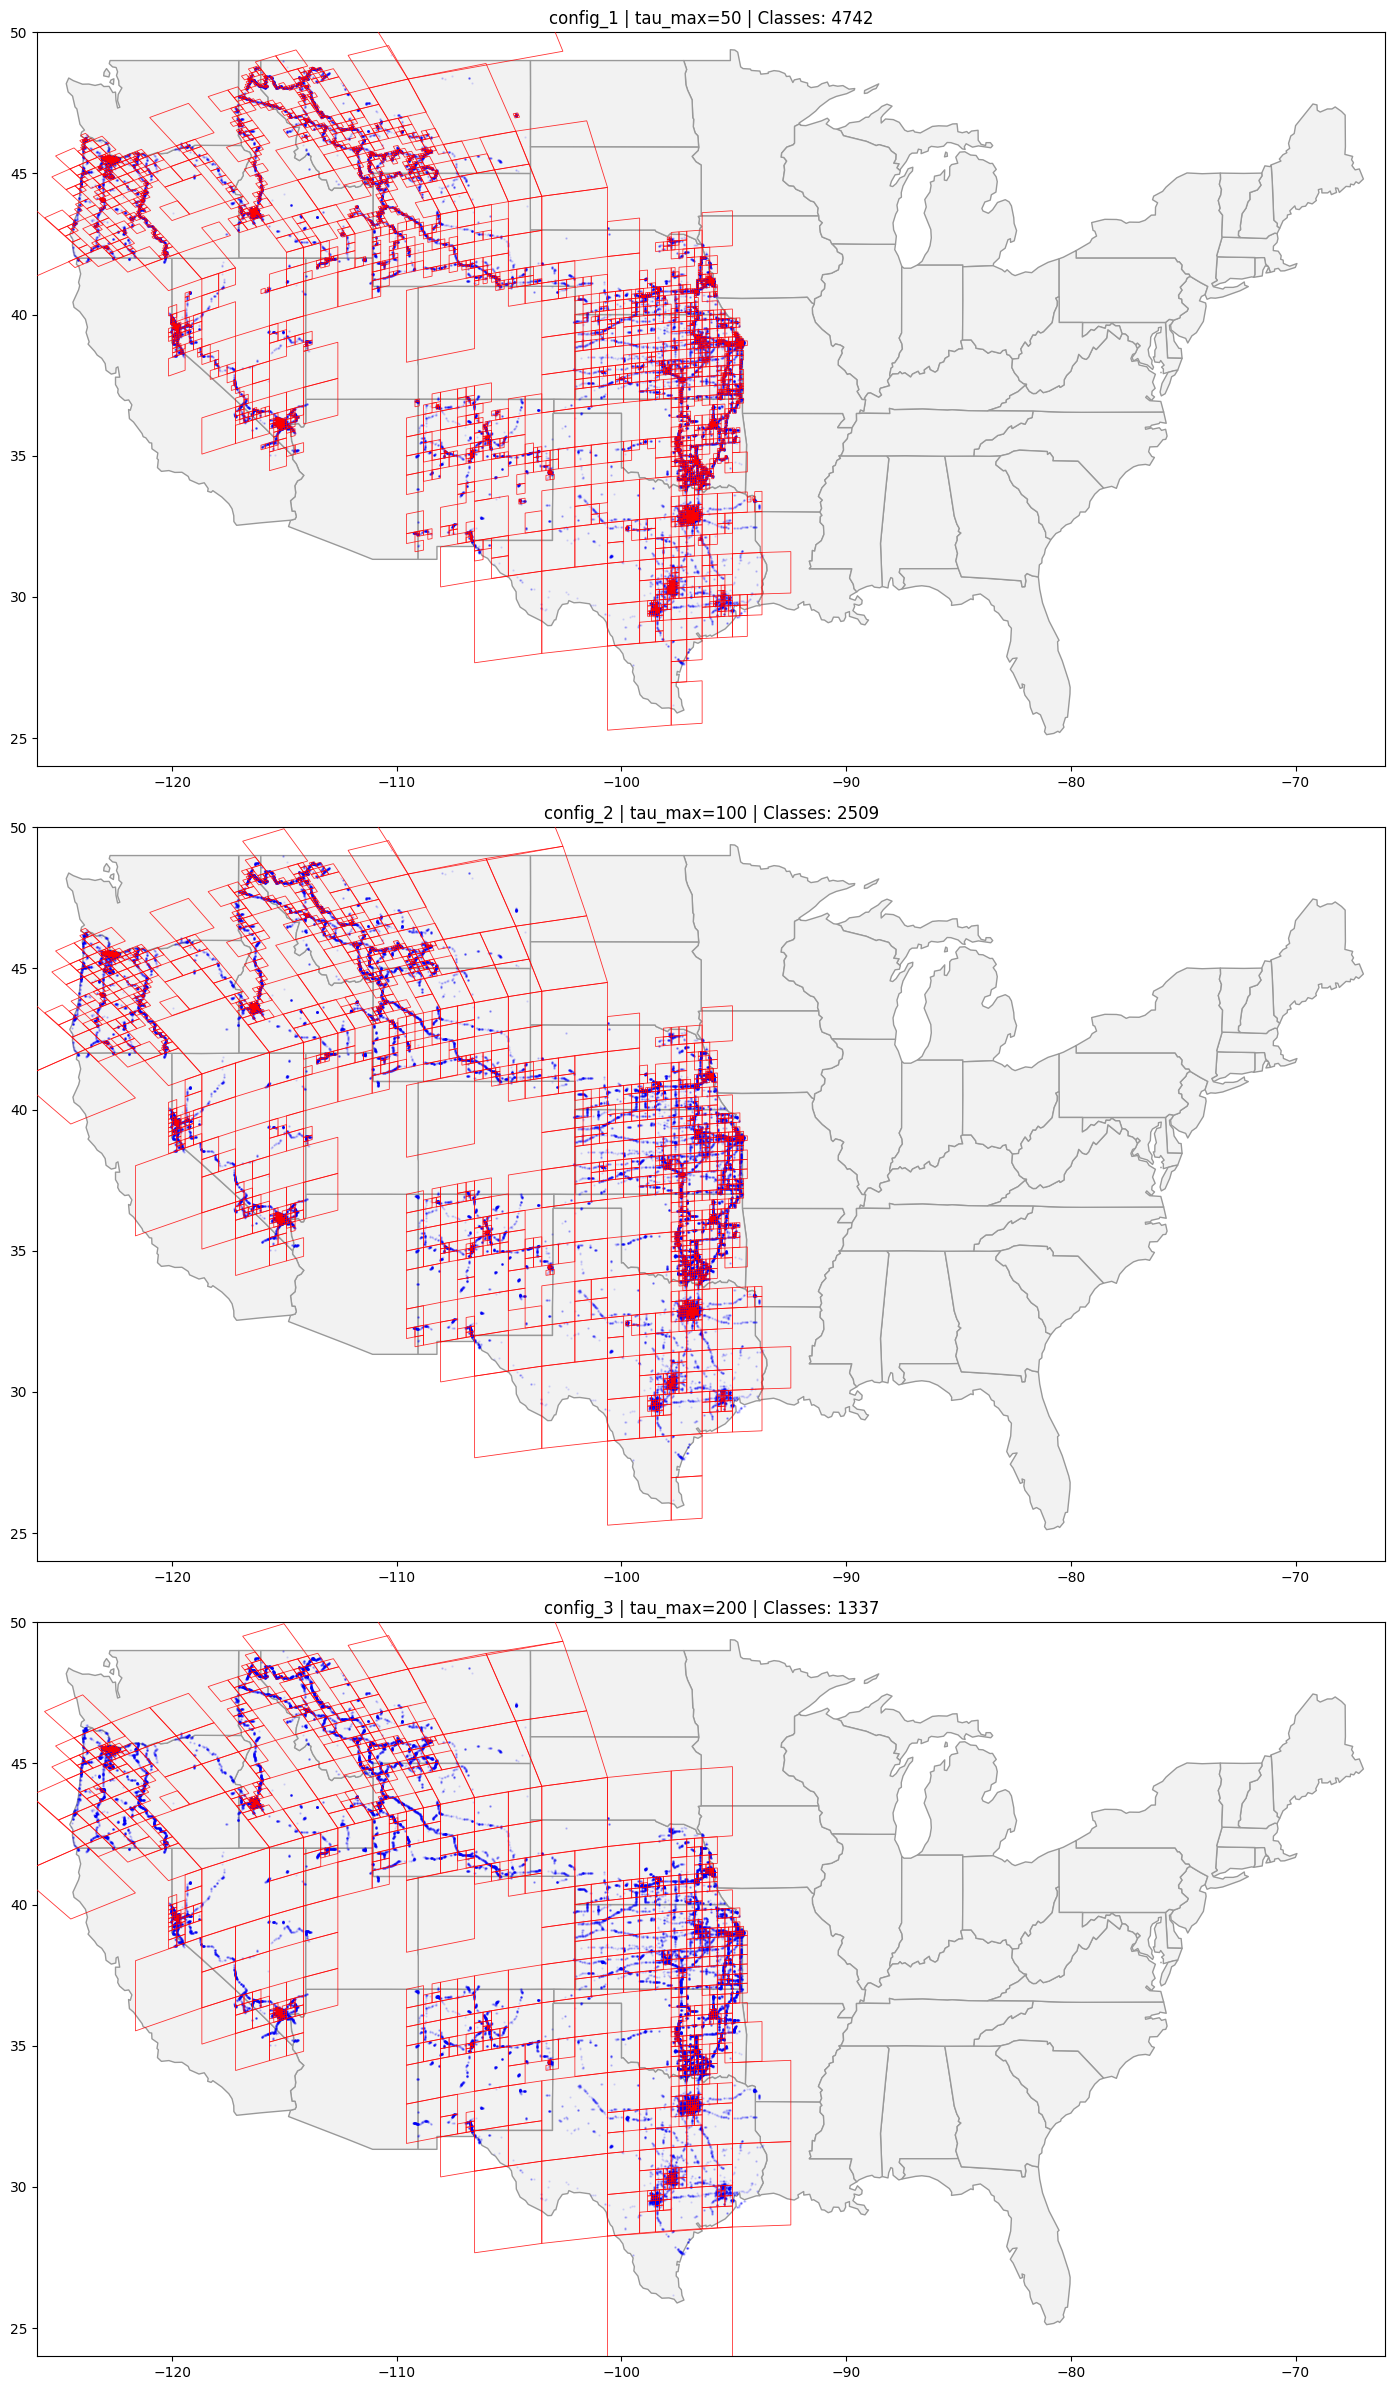


S2 Cell Map Generation Completed


In [10]:
plot_s2_cell_maps(
    configs=cfg.PARTITION_CONFIGS,
    trained_partitions=trained_partitions,
    df_train=df_train,
    usa=usa,
    save_images=False  
)

In [11]:
# --- 6. CREATE AND CELL CENTER DATASET ---
combined_cell_df = create_cell_center_dataset(cfg.PARTITION_CONFIGS, trained_partitions)

# Display preview
print("Combined Cell Centers DataFrame (first 5 rows):")
display(combined_cell_df.head())

Reconstructing cell centers for each configuration...


   Processing config_3 cells: 100%|██████████| 1337/1337 [00:00<00:00, 78973.98it/s]

Combined Cell Centers DataFrame created.
Total rows in the combined DataFrame: 8588
Combined Cell Centers DataFrame (first 5 rows):


,cell_id_token,center_latitude,center_longitude,count,config_name
0,86d84,32.648380,-109.188005,5,config_1
1,86d904,32.286026,-108.712579,42,config_1
2,86d914,32.139738,-108.522571,1,config_1
3,86d91c,32.314937,-108.522571,8,config_1
4,86d99,31.804084,-108.997769,6,config_1


In [12]:
# --- 7. SAVE RESULTS (Optional) ---
print(f"Saving partitioned data to: {cfg.OUTPUT_TRAIN}")
df_train.to_csv(cfg.OUTPUT_TRAIN, index=False)

print(f"Saving center datasets to: {cfg.OUTPUT_CELL_CENTER}")
combined_cell_df.to_csv(cfg.OUTPUT_CELL_CENTER, index=False)


Saving partitioned data to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/train_val_split_geocells.csv
Saving center datasets to: /content/GeoLoc-CVCS/data/metadata/s2-geo-cells/cell_center_dataset.csv
